# setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!mkdir '/content/drive/MyDrive/medsiglip-demo'

mkdir: cannot create directory ‘/content/drive/MyDrive/medsiglip-demo’: File exists


In [3]:
%cd /content/drive/MyDrive/medsiglip-demo

/content/drive/MyDrive/medsiglip-demo


In [4]:
!git clone https://github.com/simula/hyper-kvasir.git

fatal: destination path 'hyper-kvasir' already exists and is not an empty directory.


In [5]:
from types import SimpleNamespace
from pathlib import Path
import pandas as pd
from datetime import datetime

config = SimpleNamespace()

config.base_dir = Path('/content/drive/MyDrive/medsiglip-demo')
config.tmp_dir = Path('/content')
config.data_dir = config.tmp_dir / 'data'
config.output_dir = config.base_dir / 'output'
config.language = 'ja'  # ja or en

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
config.timestamp = timestamp

In [6]:
import os
import sys

if "google.colab" in sys.modules and not os.environ.get("VERTEX_PRODUCT"):
    # Use secret if running in Google Colab
    from google.colab import userdata
    os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")
else:
    # Store Hugging Face data under `/content` if running in Colab Enterprise
    if os.environ.get("VERTEX_PRODUCT") == "COLAB_ENTERPRISE":
        os.environ["HF_HOME"] = "/content/hf"
    # Authenticate with Hugging Face
    from huggingface_hub import get_token
    if get_token() is None:
        from huggingface_hub import notebook_login
        notebook_login()

In [7]:
! pip install --upgrade --quiet accelerate datasets evaluate tensorboard transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 122.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 98.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.19.0 requires tensorboard~=2.19.0, but you have tensorboard 2.20.0 which is incompatible.


## download dataset

今回使用するデータセットをダウンロードします．

In [8]:
import os
import requests
import zipfile
from pathlib import Path
from tqdm import tqdm

def download_and_extract_with_progress(url, save_path, extract=False):
    """
    指定されたURLからファイルをダウンロードし，進捗と速度をリアルタイムで表示する．
    必要に応じて解凍も行う．

    Args:
        url (str): ダウンロードするファイルのURL．
        save_path (Union[str, Path]): ファイルを保存するパス．
        extract (bool, optional): Trueの場合，ダウンロードしたZIPファイルを解凍する．
                                  デフォルトは False．

    Raises:
        requests.exceptions.RequestException: ネットワークエラーやHTTPエラーが発生した場合．
        zipfile.BadZipFile: ダウンロードしたファイルが有効なZIPファイルでない場合．

    Usage:
    >>> url = "https://example.com/file.zip"
    >>> save_path = "downloads/file.zip"
    >>> download_and_extract_with_progress(url, save_path, extract=True)
    """
    # 保存先のディレクトリを作成
    save_path = Path(save_path)
    directory = save_path.parent
    if not directory.exists():
        directory.mkdir(parents=True)
        print(f"ディレクトリを作成しました: {directory}")

    response = requests.get(url, stream=True)
    response.raise_for_status()  # ステータスコードが200番台でない場合は例外を発生させる

    total_size = int(response.headers.get('content-length', 0))

    # チャンクサイズを定義
    # chunk_size = 8192  # 8KB
    chunk_size = 1024 * 1024  # 1MB

    print(f"'{save_path.name}' をダウンロード中...")

    with open(save_path, "wb") as file, tqdm(
        desc=save_path.name,
        total=total_size,
        unit='B',
        unit_scale=True,
        unit_divisor=1024,  # KB, MB の単位に自動変換
        ncols=100,
    ) as bar:
        for chunk in response.iter_content(chunk_size=chunk_size):
            if chunk:
                size = file.write(chunk)
                bar.update(size)

    print("ダウンロードが完了しました．")

    # 解凍する場合
    if extract and save_path.suffix == '.zip':
        print("ファイルを解凍中...")
        with zipfile.ZipFile(save_path, 'r') as zip_ref:
            # Zipファイル内のファイルリストでプログレスバーを作成
            file_list = zip_ref.infolist()
            extract_path = str(save_path.parent)
            with tqdm(total=len(file_list), desc="解凍中", ncols=100) as pbar:
                for member in file_list:
                    zip_ref.extract(member, extract_path)
                    pbar.update(1)
        print("解凍が完了しました．")


# --- 使用例 ---
url = 'https://datasets.simula.no/downloads/hyper-kvasir/hyper-kvasir-labeled-images.zip'
save_path = config.data_dir / 'hyper-kvasir-labeled-images.zip'
if not save_path.exists():
  download_and_extract_with_progress(url, save_path, extract=True)
else:
  print(f'このzipファイルはすでにあります\n{save_path}')

ディレクトリを作成しました: /content/data
'hyper-kvasir-labeled-images.zip' をダウンロード中...


hyper-kvasir-labeled-images.zip: 100%|█████████████████████████| 3.66G/3.66G [04:11<00:00, 15.6MB/s]


ダウンロードが完了しました．
ファイルを解凍中...


解凍中: 100%|████████████████████████████████████████████████| 10696/10696 [00:17<00:00, 600.33it/s]

解凍が完了しました．


1min30s

## Datasetを作成

In [9]:
csv_path = config.data_dir / "labeled-images/image-labels.csv"
df = pd.read_csv(csv_path)

使用するクラス分類用のラベルを設定

In [10]:
# 取得したlabelsをpaperと同様の順番に並び替え
labels = ['barretts',
    'bbps-0-1',
    'bbps-2-3',
    'dyed-lifted-polyps',
    'dyed-resection-margins',
    'hemorrhoids',
    'ileum',
    'impacted-stool',
    'cecum',
    'pylorus',
    'z-line',
    'oesophagitis-a',
    'oesophagitis-b-d',
    'polyp',
    'retroflex-rectum',
    'retroflex-stomach',
    'short-segment-barretts',
    'ulcerative-colitis-grade-0-1',
    'ulcerative-colitis-grade-1-2',
    'ulcerative-colitis-grade-2-3',
    'ulcerative-colitis-grade-1',
    'ulcerative-colitis-grade-2',
    'ulcerative-colitis-grade-3',
]

# 単語として不自然な，-をスペースに置換
labels_en = ['barretts',
    'bbps 0-1',
    'bbps 2-3',
    'dyed lifted polyps',
    'dyed resection margins',
    'hemorrhoids',
    'ileum',
    'impacted stool',
    'cecum',
    'pylorus',
    'z line',
    'oesophagitis a',
    'oesophagitis b-d',
    'polyp',
    'retroflex rectum',
    'retroflex stomach',
    'barretts short segment',
    'ulcerative colitis grade 0-1',
    'ulcerative colitis grade 1-2',
    'ulcerative colitis grade 2-3',
    'ulcerative colitis grade 1',
    'ulcerative colitis grade 2',
    'ulcerative colitis grade 3'
]

# 日本語のラベルリスト(Gemini 2.5 Pro で自動翻訳)
labels_ja = [
    'バレット食道',                 # barretts
    'BBPS 0-1',                     # bbps 0-1 (ボストン・スケール 0-1)
    'BBPS 2-3',                     # bbps 2-3 (ボストン・スケール 2-3)
    '色素散布後の隆起性ポリープ',   # dyed lifted polyps
    '色素散布後の切除断端',       # dyed resection margins
    '痔核',                         # hemorrhoids
    '回腸',                         # ileum
    '憩室',                       # impacted stool
    '盲腸',                         # cecum
    '幽門',                         # normal pylorus
    'Z線',                          # z line (食道胃接合部)
    '食道炎 グレードA',             # oesophagitis a
    '食道炎 グレードB-D',            # oesophagitis b-d
    'ポリープ',                     # polyp
    '直腸反転観察',                 # retroflex rectum
    '胃反転観察',                 # retroflex stomach
    '短区域バレット食道',           # barretts short segment
    '潰瘍性大腸炎 グレード0-1',    # ulcerative colitis grade 0-1
    '潰瘍性大腸炎 グレード1-2',    # ulcerative colitis grade 1-2
    '潰瘍性大腸炎 グレード2-3',    # ulcerative colitis grade 2-3
    '潰瘍性大腸炎 グレード1',     # ulcerative colitis grade 1
    '潰瘍性大腸炎 グレード2',     # ulcerative colitis grade 2
    '潰瘍性大腸炎 グレード3'      # ulcerative colitis grade 3
]

In [11]:
split_5_path = config.base_dir / "hyper-kvasir/official_splits/5_fold_split.csv"

df_split_5 = pd.read_csv(split_5_path, sep=';')
display(df_split_5)

,file-name,class-name,split-index
0,4bf58f1c-8233-41fc-9614-344e6d0fc351.jpg,impacted-stool,0
1,9c3e5380-9621-4e74-b937-0c46f37e7ef3.jpg,impacted-stool,0
2,cf3667be-0c86-4ce7-a0f3-721144b67230.jpg,impacted-stool,0
3,8dbf6ead-8801-4a28-b811-62567dd2edb5.jpg,impacted-stool,0
4,af09c241-1417-4a42-91ef-df86bab65f7c.jpg,impacted-stool,0
...,...,...,...
10657,ed63fc63-736a-46c8-af90-fb4270c6098e.jpg,ulcerative-colitis-grade-1-2,3
10658,00064260-95ca-47fc-9103-2b526f59fada.jpg,ulcerative-colitis-grade-1-2,3
10659,239af4ae-b703-4f3b-8e31-425499d4cdbc.jpg,ulcerative-colitis-grade-1-2,4
10660,3e418689-3b22-494c-a463-376cd39d9d0c.jpg,ulcerative-colitis-grade-1-2,4


In [12]:
class_names = df_split_5['class-name'].unique().tolist()
class_names = sorted(class_names)
print(len(class_names))
class_names

23


['barretts',
 'bbps-0-1',
 'bbps-2-3',
 'dyed-lifted-polyps',
 'dyed-resection-margins',
 'hemorroids',
 'ileum',
 'impacted-stool',
 'normal-cecum',
 'normal-pylorus',
 'normal-z-line',
 'oesophagitis-a',
 'oesophagitis-b-d',
 'polyp',
 'retroflex-rectum',
 'retroflex-stomach',
 'short-segment-barretts',
 'ulcerative-colitis-grade-0-1',
 'ulcerative-colitis-grade-1',
 'ulcerative-colitis-grade-1-2',
 'ulcerative-colitis-grade-2',
 'ulcerative-colitis-grade-2-3',
 'ulcerative-colitis-grade-3']

In [13]:
labels_dict = df.set_index('Video file').to_dict(orient='index')
labels_dict

{'000e3fee-7f5c-4819-9f9c-4c983b68888a': {'Organ': 'Lower GI',
  'Finding': 'cecum',
  'Classification': 'anatomical-landmarks'},
 '001a41c2-2a5d-40b1-8fd5-b5f2f292277b': {'Organ': 'Lower GI',
  'Finding': 'cecum',
  'Classification': 'anatomical-landmarks'},
 '006af0aa-2044-4477-964d-10d9e043fb78': {'Organ': 'Lower GI',
  'Finding': 'cecum',
  'Classification': 'anatomical-landmarks'},
 '00832522-ab8e-4b98-bfce-93a777929571': {'Organ': 'Lower GI',
  'Finding': 'cecum',
  'Classification': 'anatomical-landmarks'},
 '012ab888-64e6-4361-9745-f52b4a03ba75': {'Organ': 'Lower GI',
  'Finding': 'cecum',
  'Classification': 'anatomical-landmarks'},
 '014a6880-6306-47ab-8766-adc17507b7c3': {'Organ': 'Lower GI',
  'Finding': 'cecum',
  'Classification': 'anatomical-landmarks'},
 '019975d6-14e2-4a71-9e35-934f2280fab6': {'Organ': 'Lower GI',
  'Finding': 'cecum',
  'Classification': 'anatomical-landmarks'},
 '01b2ec26-e814-4053-a820-37c9b703d47a': {'Organ': 'Lower GI',
  'Finding': 'cecum',
  'Cl

In [14]:
import pandas as pd
import numpy as np


def process_row_and_get_info(row):
    file_name = row['file-name']
    file_base = file_name.split('.')[0]
    class_name = row['class-name']

    info = labels_dict.get(file_base)

    # 辞書に情報がなければ、すべての新しい列に欠損値を返します．
    if not info:
        print(f"No info found for: {file_base}")
        return np.nan, np.nan, np.nan, np.nan

    organ = info['Organ']
    classification = info['Classification']
    finding = info['Finding']

    # ファイルパスを構築します．
    organ_path = organ.lower().replace(' ', '-')
    class_path = classification.lower().replace(' ', '-')
    file_path = config.data_dir / "labeled-images" / f"{organ_path}-tract" / class_path / finding / file_name

    # ファイルが存在しない場合はパスを欠損値とします．
    if not file_path.exists():
        print(f"File not found: {file_path}")
        # ファイルがなくても他のメタ情報は返します．
        return np.nan, organ, classification, finding

    file_path = str(file_path)

    # labelsのlabelのindexの番号から，英語と日本語のラベル列を作成
    print(class_name)
    # replace misspelling
    if class_name not in labels:
        missing_dict = {
            'hemorroids': 'hemorrhoids',
            'oesophagitis-b-d': 'esophagitis-b-d',
            'normal-cecum': 'cecum',
            'normal-pylorus': 'pylorus',
            'normal-z-line': 'z-line',
        }
        class_name = missing_dict.get(class_name, class_name)
    index_number = labels.index(class_name)
    print(index_number)
    label_en = labels_en[index_number]
    label_ja = labels_ja[index_number]

    return file_path, organ, classification, finding, label_en, label_ja


# .applyを使い、一度に複数の新しい列を作成します．
# new_columns = ['file_path', 'Organ', 'Classification', 'Finding']
new_columns = ['file_path', 'Organ', 'Classification', 'Finding', 'label_en', 'label_ja']
df_split_5[new_columns] = df_split_5.apply(process_row_and_get_info, axis=1, result_type='expand')

df_split_5["file_path"] = df_split_5["file_path"].astype(str)

# 結果を表示
df_split_5

Streaming output truncated to the last 5000 lines.
dyed-resection-margins
4
dyed-resection-margins
4
dyed-resection-margins
4
dyed-resection-margins
4
dyed-resection-margins
4
dyed-resection-margins
4
dyed-resection-margins
4
dyed-resection-margins
4
dyed-resection-margins
4
dyed-resection-margins
4
dyed-resection-margins
4
dyed-resection-margins
4
dyed-resection-margins
4
dyed-resection-margins
4
dyed-resection-margins
4
dyed-resection-margins
4
dyed-resection-margins
4
dyed-resection-margins
4
dyed-resection-margins
4
dyed-resection-margins
4
dyed-resection-margins
4
dyed-resection-margins
4
dyed-resection-margins
4
dyed-resection-margins
4
dyed-resection-margins
4
dyed-resection-margins
4
dyed-resection-margins
4
dyed-resection-margins
4
dyed-resection-margins
4
dyed-resection-margins
4
dyed-resection-margins
4
dyed-resection-margins
4
dyed-resection-margins
4
dyed-resection-margins
4
dyed-resection-margins
4
dyed-resection-margins
4
dyed-resection-margins
4
dyed-resection-margins
4

,file-name,class-name,split-index,file_path,Organ,Classification,Finding,label_en,label_ja
0,4bf58f1c-8233-41fc-9614-344e6d0fc351.jpg,impacted-stool,0,/content/data/labeled-images/lower-gi-tract/qu...,Lower GI,quality-of-mucosal-views,impacted-stool,impacted stool,憩室
1,9c3e5380-9621-4e74-b937-0c46f37e7ef3.jpg,impacted-stool,0,/content/data/labeled-images/lower-gi-tract/qu...,Lower GI,quality-of-mucosal-views,impacted-stool,impacted stool,憩室
2,cf3667be-0c86-4ce7-a0f3-721144b67230.jpg,impacted-stool,0,/content/data/labeled-images/lower-gi-tract/qu...,Lower GI,quality-of-mucosal-views,impacted-stool,impacted stool,憩室
3,8dbf6ead-8801-4a28-b811-62567dd2edb5.jpg,impacted-stool,0,/content/data/labeled-images/lower-gi-tract/qu...,Lower GI,quality-of-mucosal-views,impacted-stool,impacted stool,憩室
4,af09c241-1417-4a42-91ef-df86bab65f7c.jpg,impacted-stool,0,/content/data/labeled-images/lower-gi-tract/qu...,Lower GI,quality-of-mucosal-views,impacted-stool,impacted stool,憩室
...,...,...,...,...,...,...,...,...,...
10657,ed63fc63-736a-46c8-af90-fb4270c6098e.jpg,ulcerative-colitis-grade-1-2,3,/content/data/labeled-images/lower-gi-tract/pa...,Lower GI,pathological-findings,ulcerative-colitis-grade-1-2,ulcerative colitis grade 1-2,潰瘍性大腸炎 グレード1-2
10658,00064260-95ca-47fc-9103-2b526f59fada.jpg,ulcerative-colitis-grade-1-2,3,/content/data/labeled-images/lower-gi-tract/pa...,Lower GI,pathological-findings,ulcerative-colitis-grade-1-2,ulcerative colitis grade 1-2,潰瘍性大腸炎 グレード1-2
10659,239af4ae-b703-4f3b-8e31-425499d4cdbc.jpg,ulcerative-colitis-grade-1-2,4,/content/data/labeled-images/lower-gi-tract/pa...,Lower GI,pathological-findings,ulcerative-colitis-grade-1-2,ulcerative colitis grade 1-2,潰瘍性大腸炎 グレード1-2
10660,3e418689-3b22-494c-a463-376cd39d9d0c.jpg,ulcerative-colitis-grade-1-2,4,/content/data/labeled-images/lower-gi-tract/pa...,Lower GI,pathological-findings,ulcerative-colitis-grade-1-2,ulcerative colitis grade 1-2,潰瘍性大腸炎 グレード1-2


ローカル（google drive）上に保存か，HF上に保存できるようにしております．こちらはコメントアウトしております．

In [15]:
import pandas as pd
from datasets import Dataset, DatasetDict, Image, ClassLabel
from pathlib import Path
from huggingface_hub import login


# 1. Hugging Face Hubのリポジトリ名
# (事前にHubで作成しておくか，private=Trueで自動作成できます)
# HF_REPO_NAME = "your-username/your-dataset-name"
LOCAL_SAVE_PATH = "hyper-kvasir-local"

# これを実行するとトークンの入力を求められます．
# 事前にターミナルで `huggingface-cli login` を実行済みであれば不要です．
# print("Hugging Face Hubにログインします．アクセストークンを準備してください．")
# login()


df = df_split_5

# Hugging Faceの標準的な列名に合わせます．
# 'class-name' -> 'label'
df = df.rename(columns={"file_path": "image"})

# --- 'split-index'列に基づいてデータを分割 ---
print("'split-index'列に基づいてデータを train/validation/test に分割します．．．")

df_train = df[df['split-index'].isin([0, 1, 2])].reset_index(drop=True)
df_val = df[df['split-index'] == 3].reset_index(drop=True)
df_test = df[df['split-index'] == 4].reset_index(drop=True)


print(f"分割後のサンプル数:")
print(f"  Train: {len(df_train)}")
print(f"  Validation: {len(df_val)}")
print(f"  Test: {len(df_test)}")
# -----------------------------------------

print("\nPandasデータフレームからHugging Face DatasetDictを作成しています．．．")
# 各データフレームからDatasetを作成
train_dataset = Dataset.from_pandas(df_train, preserve_index=False)
val_dataset = Dataset.from_pandas(df_val, preserve_index=False)
test_dataset = Dataset.from_pandas(df_test, preserve_index=False)

# DatasetDictにまとめる
dataset_dict = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

# 'image'列を文字列のパスからImageオブジェクトに変換するように設定
print("'image'列を画像形式に変換しています．．．")
dataset_dict = dataset_dict.cast_column("image", Image())

# (任意) ラベルをClassLabel形式に変換
print("'label'列をClassLabel形式に変換しています．．．")


# print(f"\nデータセットを '{HF_REPO_NAME}' にアップロードします．")
# `private=True` にすると，非公開データセットとしてアップロードできます．
# dataset_dict.push_to_hub(HF_REPO_NAME, private=True)
# save_path = config.data_dir / LOCAL_SAVE_PATH
print(f"\nデータセットを '{save_path}' に保存します．")
dataset_dict.save_to_disk(f'{config.data_dir / LOCAL_SAVE_PATH}')


print("\nアップロードが完了しました！")
# print(f"Hubでデータセットを確認してください: https://huggingface.co/datasets/{HF_REPO_NAME}")
print(f"データセットは次の場所に保存されています: {Path(LOCAL_SAVE_PATH).resolve()}")



'split-index'列に基づいてデータを train/validation/test に分割します．．．
分割後のサンプル数:
  Train: 6366
  Validation: 2122
  Test: 2174

PandasデータフレームからHugging Face DatasetDictを作成しています．．．
'image'列を画像形式に変換しています．．．
'label'列をClassLabel形式に変換しています．．．

データセットを '/content/data/hyper-kvasir-labeled-images.zip' に保存します．


Saving the dataset (0/3 shards):   0%|          | 0/6366 [00:00<?, ? examples/s]

Saving the dataset (0/2 shards):   0%|          | 0/2122 [00:00<?, ? examples/s]

Saving the dataset (0/2 shards):   0%|          | 0/2174 [00:00<?, ? examples/s]


アップロードが完了しました！
データセットは次の場所に保存されています: /content/drive/MyDrive/medsiglip-demo/hyper-kvasir-local


# training

## 学習のsetup

In [16]:
import torch
from transformers import AutoProcessor, AutoModel
import torch


model_id = "google/medsiglip-448"
# model_id = config.model_cache / model_id
model_id = str(model_id)


model = AutoModel.from_pretrained(model_id)
processor = AutoProcessor.from_pretrained(model_id)

config.json:   0%|          | 0.00/879 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.51G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/360 [00:00<?, ?B/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/809 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/455 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

In [17]:
from datasets import Dataset, DatasetDict, Features, ClassLabel, Value, Array2D, load_dataset, load_from_disk

# data = load_dataset(dataset_id, split="train")
dataset_id = config.data_dir / LOCAL_SAVE_PATH
# data = load_dataset(dataset_id)

# ディスクからデータセットを読み込む
data = load_from_disk(dataset_id)
print(data)

DatasetDict({
    train: Dataset({
        features: ['file-name', 'class-name', 'split-index', 'image', 'Organ', 'Classification', 'Finding', 'label_en', 'label_ja'],
        num_rows: 6366
    })
    validation: Dataset({
        features: ['file-name', 'class-name', 'split-index', 'image', 'Organ', 'Classification', 'Finding', 'label_en', 'label_ja'],
        num_rows: 2122
    })
    test: Dataset({
        features: ['file-name', 'class-name', 'split-index', 'image', 'Organ', 'Classification', 'Finding', 'label_en', 'label_ja'],
        num_rows: 2174
    })
})


Inspect a sample data point, which contains:

* `image`: image patch as a `PIL` image object
* `label`: integer class label corresponding to tissue type

In [18]:
# Copy language-specific label column into a unified "label" feature.
src_key = f"label_{config.language}"
def copy_label(examples):
    examples["label"] = examples[src_key]
    return examples

data = data.map(copy_label, batched=True)

for split, ds in data.items():
    print(f"{split}: columns -> {ds.column_names[:10]} (rows: {len(ds)})")


Map:   0%|          | 0/6366 [00:00<?, ? examples/s]

Map:   0%|          | 0/2122 [00:00<?, ? examples/s]

Map:   0%|          | 0/2174 [00:00<?, ? examples/s]

train: columns -> ['file-name', 'class-name', 'split-index', 'image', 'Organ', 'Classification', 'Finding', 'label_en', 'label_ja', 'label'] (rows: 6366)
validation: columns -> ['file-name', 'class-name', 'split-index', 'image', 'Organ', 'Classification', 'Finding', 'label_en', 'label_ja', 'label'] (rows: 2122)
test: columns -> ['file-name', 'class-name', 'split-index', 'image', 'Organ', 'Classification', 'Finding', 'label_en', 'label_ja', 'label'] (rows: 2174)


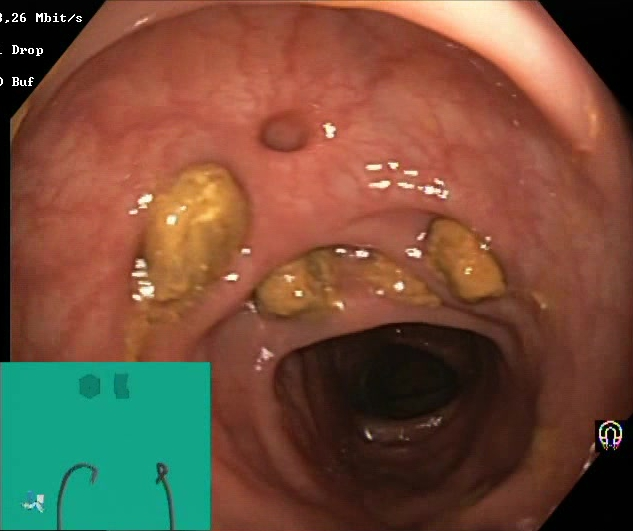

In [19]:
data['train'][0]["image"]

In [20]:
data['train'][0]["label"]

'憩室'

In [21]:
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, InterpolationMode


CLASSES = labels_ja if config.language == "ja" else labels_en

# size = processor.image_processor.size["height"]
size = 448
mean = processor.image_processor.image_mean
std = processor.image_processor.image_std

_transform = Compose([
    Resize((size, size), interpolation=InterpolationMode.BILINEAR),
    ToTensor(),
    Normalize(mean=mean, std=std),
])


def preprocess(examples):
    pixel_values = [_transform(image.convert("RGB")) for image in examples["image"]]
    # captions = [CLASSES[label] for label in examples["label"]]
    # 'label'列の文字列リストをそのままキャプションとして使用
    captions = examples["label"]
    inputs = processor.tokenizer(
        captions,
        max_length=64,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
    )
    inputs["pixel_values"] = pixel_values
    return inputs


data = data.map(preprocess, batched=True, remove_columns=["image", "label"])

Map:   0%|          | 0/6366 [00:00<?, ? examples/s]

Map:   0%|          | 0/2122 [00:00<?, ? examples/s]

Map:   0%|          | 0/2174 [00:00<?, ? examples/s]

## ファインチューニングの設定

Define a data collator to prepare batches of training examples.

In [22]:
import torch


def collate_fn(examples):
    pixel_values = torch.tensor([example["pixel_values"] for example in examples])
    input_ids = torch.tensor([example["input_ids"] for example in examples])
    attention_mask = torch.tensor([example["attention_mask"] for example in examples])
    return {
        "pixel_values": pixel_values,
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "return_loss": True,
    }

メモリのメモ
- A100 GPU RAM 30GB/40GB: per_device_train_batch_size=8

In [23]:
from transformers import TrainingArguments

# num_train_epochs = 2  # @param {type: "number"}
num_train_epochs = 1  # @param {type: "number"}
learning_rate = 1e-4  # @param {type: "number"}
# demoで，max_stepsで少ないステップでdemoで動かせるようにしています．
# 学習する場合は，num_train_epochsのコメントアウトを解除してください．

save_dir = config.output_dir / f"medsiglip-448-ft-{config.language}-{config.timestamp}"

training_args = TrainingArguments(
    output_dir=save_dir,  # Directory and Hub repository id to save the model to
    # num_train_epochs=num_train_epochs,      # Number of training epochs
    max_steps=50,                           # Total number of training steps to perform
    per_device_train_batch_size=8,          # Batch size per device during training
    per_device_eval_batch_size=8,           # Batch size per device during evaluation
    gradient_accumulation_steps=1,          # Number of steps before performing a backward/update pass
    logging_steps=1,                       # Number of steps between logs
    save_strategy="epoch",                  # Save checkpoint every epoch
    eval_strategy="steps",                  # Evaluate every `eval_steps`
    eval_steps=500,                          # Number of steps between evaluations
    learning_rate=learning_rate,            # Learning rate
    weight_decay=0.01,                      # Weight decay to apply
    warmup_steps=5,                         # Number of steps for linear warmup from 0 to learning rate
    lr_scheduler_type="cosine",             # Use cosine learning rate scheduler
    push_to_hub=True,                       # Push model to Hub
    report_to="tensorboard",                      # Report metrics to tensorboard
    # report_to="wandb",                      # Report metrics to wandb
)

Construct a [`Trainer`](https://huggingface.co/docs/transformers/trainer) using the previously defined training parameters and data collator.

In [24]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data["train"],
    eval_dataset=data["validation"].shuffle().select(range(200)),  # Use subset of validation set for faster run
    data_collator=collate_fn,
)

Launch the fine-tuning process.

**Note:** This may take around 3 hours to run using the default configuration.

In [25]:
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=50, training_loss=2.966762089729309, metrics={'train_runtime': 276.4783, 'train_samples_per_second': 1.447, 'train_steps_per_second': 0.181, 'total_flos': 129052102963200.0, 'train_loss': 2.966762089729309, 'epoch': 0.06281407035175879})

Save the final model to Hugging Face Hub.

In [26]:
trainer.save_model()
print(save_dir)

/content/drive/MyDrive/medsiglip-demo/output/medsiglip-448-ft-ja-20250909_140340


# evaluate

In [27]:
# HF上でのデモ
# test_data = load_dataset(dataset_id, split="test")
# test_data

# ディスクからデータセットを読み込む
data = load_from_disk(dataset_id)
print(data)

DatasetDict({
    train: Dataset({
        features: ['file-name', 'class-name', 'split-index', 'image', 'Organ', 'Classification', 'Finding', 'label_en', 'label_ja'],
        num_rows: 6366
    })
    validation: Dataset({
        features: ['file-name', 'class-name', 'split-index', 'image', 'Organ', 'Classification', 'Finding', 'label_en', 'label_ja'],
        num_rows: 2122
    })
    test: Dataset({
        features: ['file-name', 'class-name', 'split-index', 'image', 'Organ', 'Classification', 'Finding', 'label_en', 'label_ja'],
        num_rows: 2174
    })
})


In [28]:
test_data = data['test']
test_data

Dataset({
    features: ['file-name', 'class-name', 'split-index', 'image', 'Organ', 'Classification', 'Finding', 'label_en', 'label_ja'],
    num_rows: 2174
})

In [29]:
# シンプルに language 列を "label" にリネームする
src_key = f"label_{config.language}"
test_data = test_data.rename_column(src_key, "label")
test_data


Dataset({
    features: ['file-name', 'class-name', 'split-index', 'image', 'Organ', 'Classification', 'Finding', 'label_en', 'label'],
    num_rows: 2174
})

### Set up for evaluation

Load the accuracy and F1 score metrics to evaluate the model's performance on the classfication task.

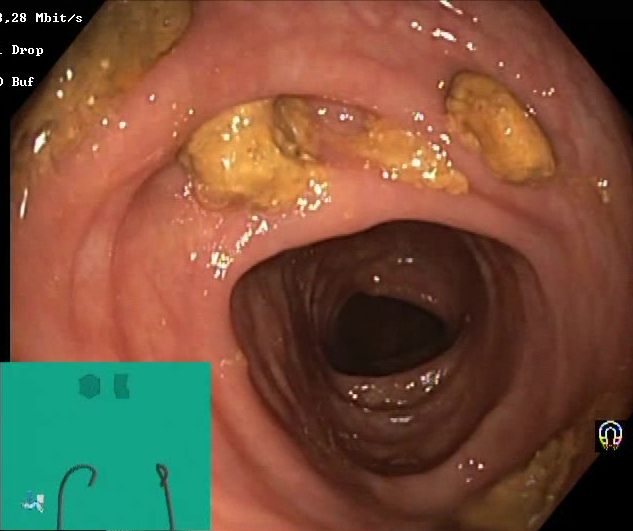

In [30]:
test_data['image'][1]

In [31]:
from transformers import pipeline
from PIL import Image
import requests

# load pipe
image_classifier = pipeline(task="zero-shot-image-classification", model=model_id)

# load image
# url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
# image = Image.open(requests.get(url, stream=True).raw)
image = test_data['image'][1]

# inference
# candidate_labels = ["2 cats", "a plane", "a remote"]
candidate_labels = CLASSES
outputs = image_classifier(image, candidate_labels=candidate_labels)
# outputs = [{"score": round(output["score"], 5), "label": output["label"] } for output in outputs]
print(outputs)
print("GT:", test_data['label'][1])

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


[{'score': 0.00039330965955741704, 'label': '潰瘍性大腸炎 グレード1'}, {'score': 0.00036952955997549, 'label': '潰瘍性大腸炎 グレード2'}, {'score': 0.00036214131978340447, 'label': '直腸反転観察'}, {'score': 0.0003347288875374943, 'label': '潰瘍性大腸炎 グレード3'}, {'score': 0.0003341281844768673, 'label': '胃反転観察'}, {'score': 0.0003078443114645779, 'label': '潰瘍性大腸炎 グレード0-1'}, {'score': 0.0002977855037897825, 'label': '潰瘍性大腸炎 グレード2-3'}, {'score': 0.0002513295621611178, 'label': '色素散布後の切除断端'}, {'score': 0.00024484508321620524, 'label': '潰瘍性大腸炎 グレード1-2'}, {'score': 0.00017223323811776936, 'label': '食道炎 グレードB-D'}, {'score': 0.00012479632277972996, 'label': '色素散布後の隆起性ポリープ'}, {'score': 0.0001142277687904425, 'label': '食道炎 グレードA'}, {'score': 8.982697181636468e-05, 'label': '盲腸'}, {'score': 7.727561751380563e-05, 'label': 'バレット食道'}, {'score': 5.7599227147875354e-05, 'label': '回腸'}, {'score': 5.528573092306033e-05, 'label': 'ポリープ'}, {'score': 5.309942935127765e-05, 'label': '短区域バレット食道'}, {'score': 4.299239662941545e-05, 'label':

In [32]:
from transformers import pipeline
from PIL import Image
import requests
import json
from tqdm import tqdm

# pipelineをロード
image_classifier = pipeline(task="zero-shot-image-classification", model=model_id)
BATCH_SIZE = 16

# 2. test_dataから全ての画像を抽出し，リストに格納します．
print("Preparing images for batch inference...")
images = [row['image'] for row in test_data]
candidate_labels = CLASSES

# 3. pipelineに画像のリストを渡し，バッチ処理で一括推論を実行します．
print(f"Running inference with batch size \n{BATCH_SIZE}")
# all_outputs = image_classifier(
#     images,
#     candidate_labels=candidate_labels,
#     batch_size=BATCH_SIZE
# )
# 結果を格納するための空のリストを用意
all_outputs = []

# imagesリストをBATCH_SIZE単位でループ処理し，そのループをtqdmでラップ
for i in tqdm(range(0, len(images), BATCH_SIZE), desc="Classifying Images"):
    # 現在のバッチに該当する画像のリストをスライスして作成
    batch_images = images[i:i + BATCH_SIZE]

    # 作成したバッチをpipelineに渡して推論を実行
    outputs = image_classifier(
        batch_images,
        candidate_labels=candidate_labels
        # ここではBATCH_SIZEの指定は不要（リスト自体がバッチのため）
    )

    # バッチごとの結果を最終的なリストに追加
    all_outputs.extend(outputs)

# 4. 推論結果と元のデータを組み合わせてファイルに書き込みます．
jsonl_path = config.output_dir / f"predictions_{config.timestamp}.jsonl"

print(f"Saving predictions to {jsonl_path}...")
with open(jsonl_path, 'w') as f:
    # zipを使って元のデータと推論結果を同時にループ処理
    for row, outputs in tqdm(zip(test_data, all_outputs), total=len(test_data), desc="Processing results"):
        top_pred = max(outputs, key=lambda x: x['score'])
        gt = row['label']
        filename = row['file-name']

        record = {
            'filename': filename,
            'prediction': top_pred['label'],
            'score': top_pred['score'],
            'ground_truth': gt,
            'outputs': outputs,
        }
        f.write(json.dumps(record) + '\n')

print("Inference completed and results saved.")

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Device set to use cuda:0


Preparing images for batch inference...
Running inference with batch size 
16


Classifying Images: 100%|██████████| 136/136 [06:15<00:00,  2.76s/it]


Saving predictions to /content/drive/MyDrive/medsiglip-demo/output/predictions_20250909_140340.jsonl...


Processing results: 100%|██████████| 2174/2174 [00:16<00:00, 131.36it/s]

Inference completed and results saved.


In [33]:
all_outputs[:1]

[[{'score': 0.00027409015456214547, 'label': '胃反転観察'},
  {'score': 0.0002618847938720137, 'label': '直腸反転観察'},
  {'score': 0.00015128005179576576, 'label': '潰瘍性大腸炎 グレード1'},
  {'score': 0.0001428224495612085, 'label': '潰瘍性大腸炎 グレード2'},
  {'score': 0.00012828079343307763, 'label': '潰瘍性大腸炎 グレード3'},
  {'score': 0.00012143437925260514, 'label': '潰瘍性大腸炎 グレード0-1'},
  {'score': 0.00011738709144992754, 'label': '潰瘍性大腸炎 グレード2-3'},
  {'score': 0.00011183615424670279, 'label': '色素散布後の切除断端'},
  {'score': 0.00010762301826616749, 'label': '色素散布後の隆起性ポリープ'},
  {'score': 0.00010218987881671637, 'label': '潰瘍性大腸炎 グレード1-2'},
  {'score': 9.064529149327427e-05, 'label': '食道炎 グレードB-D'},
  {'score': 7.641044066986069e-05, 'label': '盲腸'},
  {'score': 7.370532694039866e-05, 'label': '食道炎 グレードA'},
  {'score': 6.378612306434661e-05, 'label': 'バレット食道'},
  {'score': 5.4615939006907865e-05, 'label': '回腸'},
  {'score': 5.319552292348817e-05, 'label': 'ポリープ'},
  {'score': 4.283651287551038e-05, 'label': '幽門'},
  {'score'

In [34]:
from sklearn.metrics import accuracy_score


jsonl_path = config.output_dir / f"predictions_{config.timestamp}.jsonl"
with open(jsonl_path, 'r') as f:
    all_outputs = [json.loads(line) for line in f.readlines()]

# accで評価
# prediction, ground_truth を抽出
predictions = [record['prediction'] for record in all_outputs]
ground_truths = [record['ground_truth'] for record in all_outputs]
accuracy = accuracy_score(ground_truths, predictions)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.0676


Accuracy: 0.0681 at the demo

eval fine tuned model

In [35]:
from transformers import pipeline
from PIL import Image
import requests
import json
from tqdm import tqdm
from transformers import AutoProcessor, AutoModelForZeroShotImageClassification

# pipelineをロード
model_id_ft = config.output_dir / f"medsiglip-448-ft-{config.language}-{config.timestamp}"
model_id_ft = str(model_id_ft)
# model_id_ft = f"user_name/medsiglip-448-ft-ja-{config.timestamp}"
# image_classifier = pipeline(task="zero-shot-image-classification", model=model_id_ft)
processor = AutoProcessor.from_pretrained('google/medsiglip-448')
model = AutoModelForZeroShotImageClassification.from_pretrained(model_id_ft)

image_classifier = pipeline(
    task="zero-shot-image-classification",
    model=model,
    tokenizer=processor.tokenizer,          # processorからtokenizerを渡す
    image_processor=processor.image_processor # processorからimage_processorを渡す
)

BATCH_SIZE = 128


# 2. test_dataから全ての画像を抽出し，リストに格納します．
print("Preparing images for batch inference...")
images = [row['image'] for row in test_data]
candidate_labels = CLASSES


# 3. pipelineに画像のリストを渡し，バッチ処理で一括推論を実行します．
print(f"Running inference with batch size \n{BATCH_SIZE}")
# all_outputs = image_classifier(
#     images,
#     candidate_labels=candidate_labels,
#     batch_size=BATCH_SIZE
# )
# 結果を格納するための空のリストを用意
all_outputs = []

# imagesリストをBATCH_SIZE単位でループ処理し，そのループをtqdmでラップ
for i in tqdm(range(0, len(images), BATCH_SIZE), desc="Classifying Images"):
    # 現在のバッチに該当する画像のリストをスライスして作成
    batch_images = images[i:i + BATCH_SIZE]

    # 作成したバッチをpipelineに渡して推論を実行
    outputs = image_classifier(
        batch_images,
        candidate_labels=candidate_labels
        # ここではBATCH_SIZEの指定は不要（リスト自体がバッチのため）
    )

    # バッチごとの結果を最終的なリストに追加
    all_outputs.extend(outputs)

# 4. 推論結果と元のデータを組み合わせてファイルに書き込みます．
jsonl_path = config.output_dir / f"predictions_ft_{config.timestamp}.jsonl"

print(f"Saving predictions to \n{jsonl_path}")
with open(jsonl_path, 'w') as f:
    # zipを使って元のデータと推論結果を同時にループ処理
    for row, outputs in tqdm(zip(test_data, all_outputs), total=len(test_data), desc="Processing results"):
        top_pred = max(outputs, key=lambda x: x['score'])
        gt = row['label']
        filename = row['file-name']

        record = {
            'filename': filename,
            'prediction': top_pred['label'],
            'score': top_pred['score'],
            'ground_truth': gt,
            'outputs': outputs,
        }
        f.write(json.dumps(record) + '\n')

print("Inference completed and results saved.")

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Device set to use cuda:0


Preparing images for batch inference...
Running inference with batch size 
128


Classifying Images: 100%|██████████| 17/17 [06:16<00:00, 22.17s/it]


Saving predictions to 
/content/drive/MyDrive/medsiglip-demo/output/predictions_ft_20250909_140340.jsonl


Processing results: 100%|██████████| 2174/2174 [00:16<00:00, 130.34it/s]

Inference completed and results saved.


In [36]:
jsonl_path = config.output_dir / f'predictions_ft_{config.timestamp}.jsonl'
with open(jsonl_path, 'r') as f:
    all_outputs = [json.loads(line) for line in f.readlines()]

# accで評価
from sklearn.metrics import accuracy_score

# prediction, ground_truth を抽出
predictions = [record['prediction'] for record in all_outputs]
ground_truths = [record['ground_truth'] for record in all_outputs]
accuracy = accuracy_score(ground_truths, predictions)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.1992


In [37]:
from transformers import pipeline
from PIL import Image
import requests

# load pipe
# image_classifier = pipeline(task="zero-shot-image-classification", model=model_id)

# load image
# url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
# image = Image.open(requests.get(url, stream=True).raw)
image = test_data['image'][1]


# # 作成したバッチをpipelineに渡して推論を実行
# outputs = image_classifier(
#     batch_images,
#     candidate_labels=candidate_labels
#     # ここではBATCH_SIZEの指定は不要（リスト自体がバッチのため）
# )

# inference
# candidate_labels = ["2 cats", "a plane", "a remote"]
candidate_labels = CLASSES
outputs = image_classifier(image, candidate_labels=candidate_labels)
# outputs = [{"score": round(output["score"], 5), "label": output["label"] } for output in outputs]
print(outputs)
# Find the maximum score
max_score = max(output['score'] for output in outputs)
print(f"Maximum score: {max_score}")

# Get the top 5 outputs by score
top_5 = sorted(outputs, key=lambda x: x['score'], reverse=True)[:5]
print("Top 5 predictions:")
for i, pred in enumerate(top_5, 1):
    print(f"{i}. {pred['label']}: {pred['score']:.4f}")
print("GT:", test_data['label'][1])

[{'score': 0.005971444305032492, 'label': 'BBPS 0-1'}, {'score': 0.0030144436750561, 'label': 'BBPS 2-3'}, {'score': 0.0010417124722152948, 'label': 'Z線'}, {'score': 0.001036119763739407, 'label': '食道炎 グレードB-D'}, {'score': 0.0008971444331109524, 'label': 'ポリープ'}, {'score': 0.000857693434227258, 'label': 'バレット食道'}, {'score': 0.0008553258958272636, 'label': '食道炎 グレードA'}, {'score': 0.0007394623244181275, 'label': '短区域バレット食道'}, {'score': 0.0006784836295992136, 'label': '潰瘍性大腸炎 グレード2-3'}, {'score': 0.0006768738385289907, 'label': '潰瘍性大腸炎 グレード0-1'}, {'score': 0.000648428569547832, 'label': '潰瘍性大腸炎 グレード3'}, {'score': 0.0006458433927036822, 'label': '潰瘍性大腸炎 グレード1-2'}, {'score': 0.000642642320599407, 'label': '潰瘍性大腸炎 グレード2'}, {'score': 0.0006360720726661384, 'label': '潰瘍性大腸炎 グレード1'}, {'score': 0.0005912331398576498, 'label': '痔核'}, {'score': 0.00058342469856143, 'label': '色素散布後の切除断端'}, {'score': 0.0005187757196836174, 'label': '色素散布後の隆起性ポリープ'}, {'score': 0.0004955827025696635, 'label': '幽門'}, {